# UK Yield Curve PCA Analysis

This project demonstrates how PCA (Principal Component Analysis) can be applied to the UK yield curve to identify potential relative value (RV) trades. By decomposing the yield curve into its principal components, we aim to understand the key drivers of its movements and identify mispricings that could present trading opportunities.

### Objectives
1. Showcase data analysis skills by implementing PCA on historical yield curve data.
2. Demonstrate mathematical and statistical knowledge through the intuition and mechanics of PCA.
3. Highlight an understanding of fixed-income concepts, such as steepeners, flatteners, butterflies, and yield curve dynamics.

This analysis is particularly relevant to macro-focused trading desks at banks or hedge funds, where a deep understanding of yield curve behavior and relative value opportunities is critical.


***

### Intuition Behind PCA

PCA simplifies the analysis of the yield curve by identifying its key drivers:
1. **PC1 (Level)**: Represents parallel shifts in the curve, often driven by overall changes in interest rate levels.
2. **PC2 (Slope)**: Captures changes in the steepness of the curve, linked to monetary policy expectations.
3. **PC3 (Curvature)**: Reflects changes in the convexity of the curve, often associated with shifts in demand for intermediate maturities.

By analyzing the residuals—deviations from the modelled curve—we can identify potential mispricings that indicate trading opportunities.


In [736]:
import os
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [737]:
uk_yields = []

In [738]:
path = r"C:\Users\ddoko\OneDrive\Documents 1\Career\Resources\Trading\PCA analysis\UK rates\Yield data"
for file in os.listdir(path):
    # print(path+"\\"+file)
    tenor = pd.read_csv(path+"\\"+file, index_col="Date")
    tenor.index = pd.to_datetime(tenor.index, dayfirst=True)
    tenor = tenor['Price']
    tenor = tenor.rename(file[18:-31])
    # print(tenor)
    uk_yields.append(tenor)

uk_yields = pd.concat(uk_yields, axis=1)
uk_yields = uk_yields.dropna()
tenors = uk_yields.columns

<Axes: xlabel='Date'>

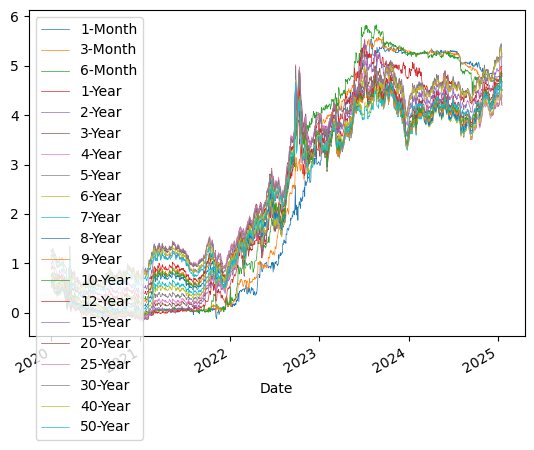

In [739]:
uk_yields.plot(lw=0.5)

<Axes: >

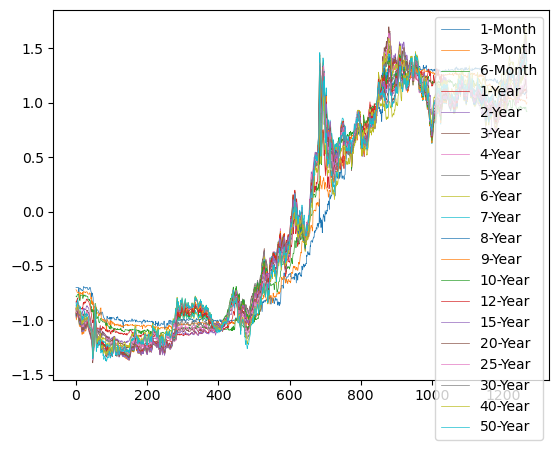

In [740]:
# Normalize the data
# yields_normalized = (uk_yields - uk_yields.mean()) / uk_yields.std()

scaler = StandardScaler()
yields_normalized = pd.DataFrame(scaler.fit_transform(np.array(uk_yields)))
yields_normalized.columns = uk_yields.columns
yields_normalized.plot(lw=0.5)

### Mathematics of PCA

PCA uses linear algebra to decompose a data matrix into orthogonal components:
\[
X = T \cdot P^T
\]
Where:
- \(X\) is the original data matrix (e.g., yield data).
- \(T\) contains the scores (projection of data onto the components).
- \(P\) contains the loadings (weights of each component).

The components are derived by maximizing the variance explained:
1. Compute the covariance matrix of the data.
2. Perform eigenvalue decomposition to identify the eigenvectors (principal components).
3. Rank components by their eigenvalues (variance explained).

In yield curve analysis, the first three components typically explain over 95% of the variance, capturing the key dynamics of level, slope, and curvature.


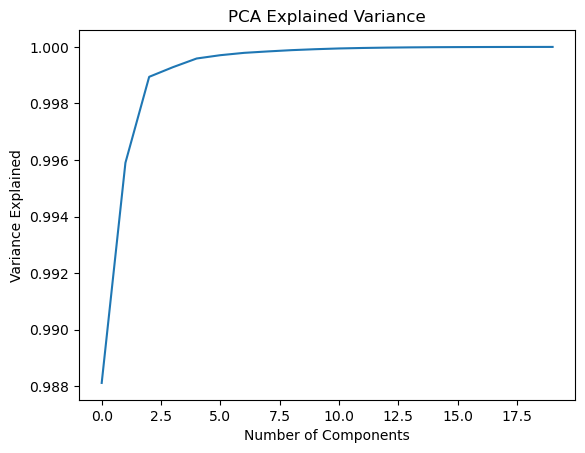

In [741]:
# Apply PCA
pca = PCA()
YC_PCA = pca.fit_transform(yields_normalized)

# Explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.title('PCA Explained Variance')
plt.show()

In [742]:
scores = pd.DataFrame(YC_PCA)
scores.index = uk_yields.index
scores_keep = scores.iloc[:, :3]
scores_keep.columns = ["PC1", "PC2", "PC3"]
# scores[:, :3]

<Axes: xlabel='Date'>

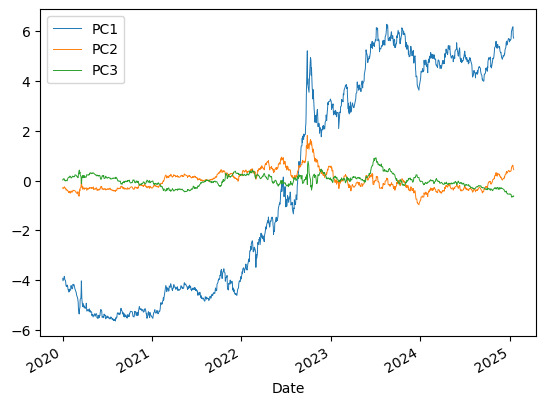

In [743]:
scores_keep.plot(lw=0.7)

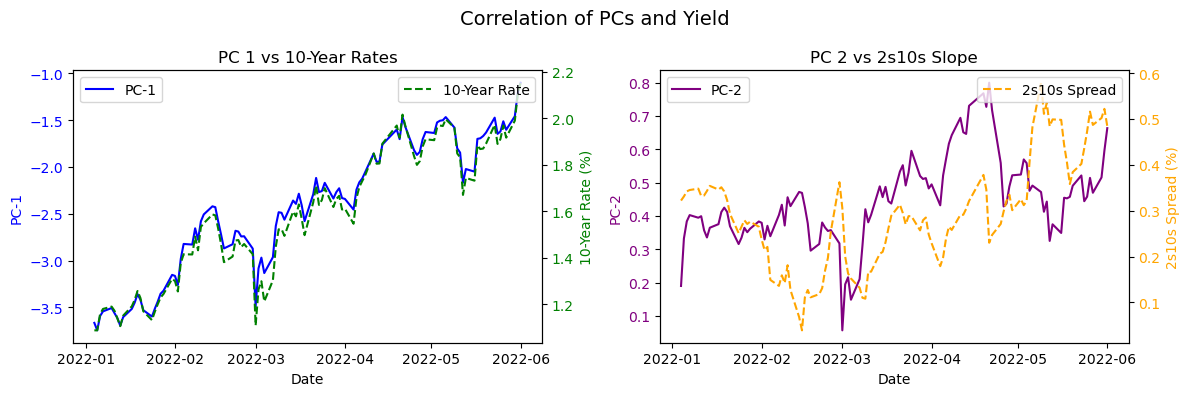

In [744]:
six_mo_PCA = scores_keep.loc[(scores_keep.index>='2022-01-01')&(scores_keep.index<='2022-06-01')]
six_mo_rates = uk_yields.loc[(uk_yields.index>='2022-01-01')&(uk_yields.index<='2022-06-01')]

fig, ax = plt.subplots(figsize=(12, 4), ncols=2, nrows=1)
plt.suptitle('Correlation of PCs and Yield', fontsize=14)

# First subplot: PC1 vs 10-Year Rate
ax1 = ax[0]
ax1.plot(six_mo_PCA.index, six_mo_PCA['PC1'], label="PC-1", color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('PC-1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax1_2 = ax1.twinx()  # Create secondary y-axis
ax1_2.plot(six_mo_rates.index, six_mo_rates['10-Year'], label="10-Year Rate", color='green', linestyle='--')
ax1_2.set_ylabel('10-Year Rate (%)', color='green')
ax1_2.tick_params(axis='y', labelcolor='green')

ax1.set_title("PC 1 vs 10-Year Rates")
ax1.legend(loc="upper left")
ax1_2.legend(loc="upper right")

# Second subplot: PC2 vs 2s10s Spread
ax2 = ax[1]
ax2.plot(six_mo_PCA.index, six_mo_PCA['PC2'], label="PC-2", color='purple')
ax2.set_xlabel('Date')
ax2.set_ylabel('PC-2', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

ax2_2 = ax2.twinx()  # Create secondary y-axis
ax2_2.plot(six_mo_rates.index, six_mo_rates['10-Year'] - six_mo_rates['2-Year'], label="2s10s Spread", color='orange', linestyle='--')
ax2_2.set_ylabel('2s10s Spread (%)', color='orange')
ax2_2.tick_params(axis='y', labelcolor='orange')

ax2.set_title("PC 2 vs 2s10s Slope")
ax2.legend(loc="upper left")
ax2_2.legend(loc="upper right")

plt.tight_layout()
plt.show()


In [745]:
loadings = pd.DataFrame(pca.components_)
loadings.columns = tenors

In [746]:
loadings[:3]

,1-Month,3-Month,6-Month,1-Year,2-Year,3-Year,4-Year,5-Year,6-Year,7-Year,8-Year,9-Year,10-Year,12-Year,15-Year,20-Year,25-Year,30-Year,40-Year,50-Year
0,0.217908,0.220620,0.222734,0.223543,0.223898,0.224076,0.224041,0.224282,0.224179,0.224186,0.224376,0.224256,0.224473,0.224497,0.224371,0.224444,0.224386,0.224301,0.223357,0.224096
1,-0.615609,-0.490003,-0.298966,-0.203305,-0.011889,0.056480,0.126520,0.134670,0.160458,0.194865,0.170566,0.185949,0.150695,0.149982,0.157328,0.087099,0.058810,0.012906,-0.064035,0.008842
2,-0.087352,0.036015,0.200054,0.227345,0.338942,0.329709,0.272230,0.196880,0.186258,0.070136,0.001967,-0.053487,-0.023122,-0.044417,-0.104710,-0.224107,-0.262731,-0.299496,-0.447181,-0.313108


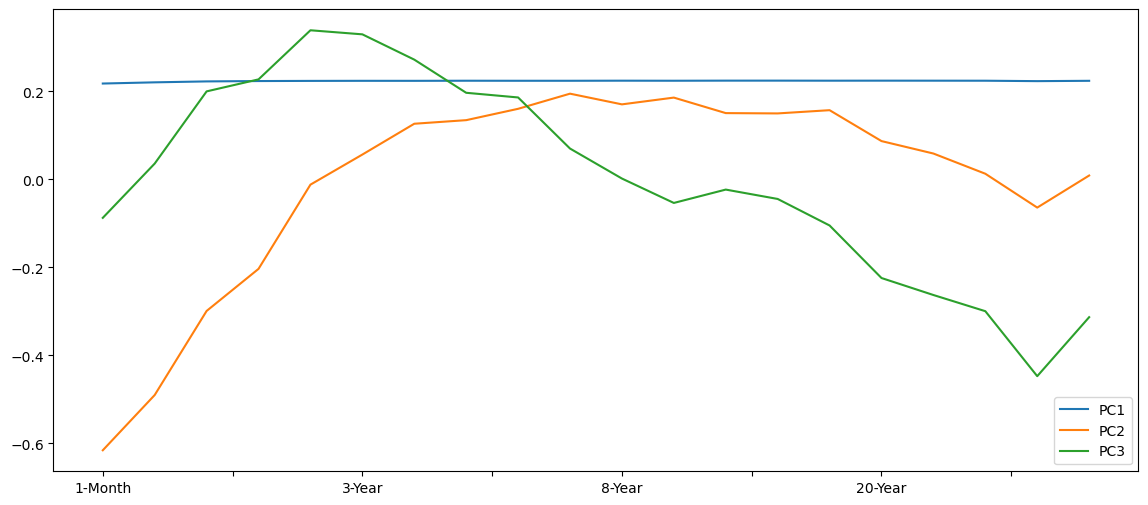

In [747]:
loadings_keep = loadings[:3].T
# loadings_keep.index = tenors
loadings_keep.columns = ["PC1", "PC2", "PC3"]
ax = loadings_keep.plot(figsize=(14,6), subplots = False)

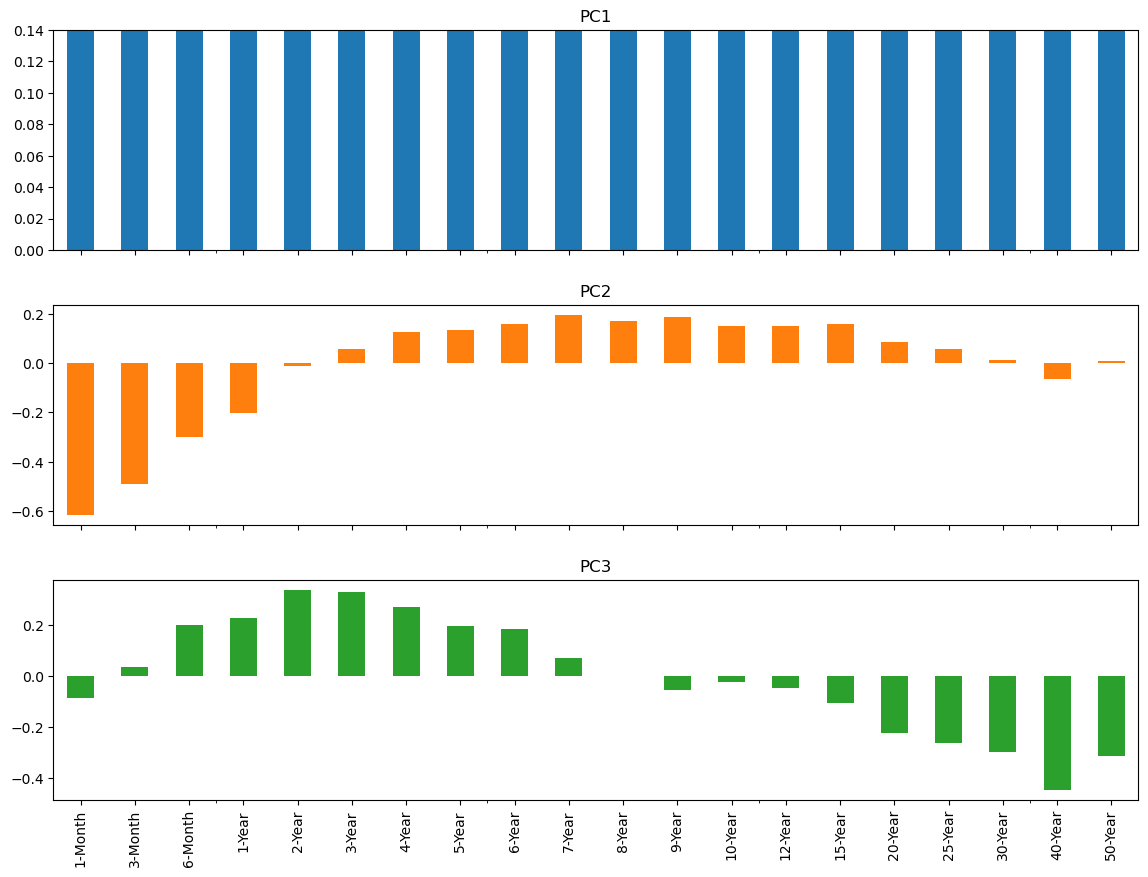

In [748]:
axs = loadings_keep.plot.bar(subplots=True,figsize=(14,10),legend=False)
plt.subplots_adjust(hspace=0.25)
axs[0].set_ylim(0,.14);



<Axes: xlabel='Date'>

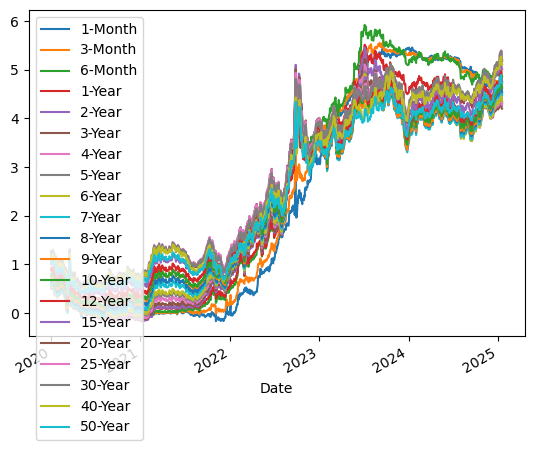

In [749]:
modelled_uk_yields = np.dot(scores_keep, loadings_keep.T)
modelled_uk_yields = scaler.inverse_transform(modelled_uk_yields)
modelled_uk_yields = pd.DataFrame(modelled_uk_yields, index= scores_keep.index, columns=tenors)
modelled_uk_yields.plot()

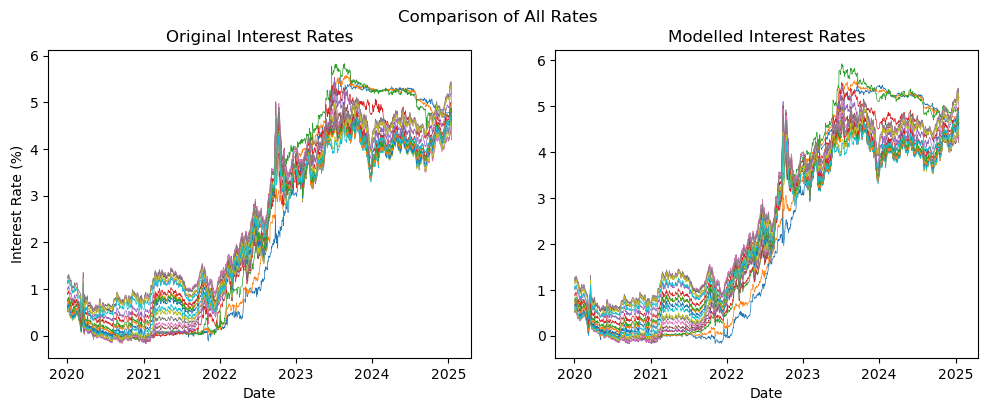

In [750]:
# Plotting before and after PCA
plot_vars = df.columns
fig, ax = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
plt.suptitle('Comparison of All Rates')
ax[0].plot(uk_yields.index, uk_yields, lw=0.5)
ax[0].set(title='Original Interest Rates', xlabel='Date', ylabel='Interest Rate (%)')

ax[1].plot(modelled_uk_yields.index, modelled_uk_yields, lw=0.5)
ax[1].set(title='Modelled Interest Rates', xlabel='Date')
plt.show()



In [751]:
residuals = uk_yields - modelled_uk_yields

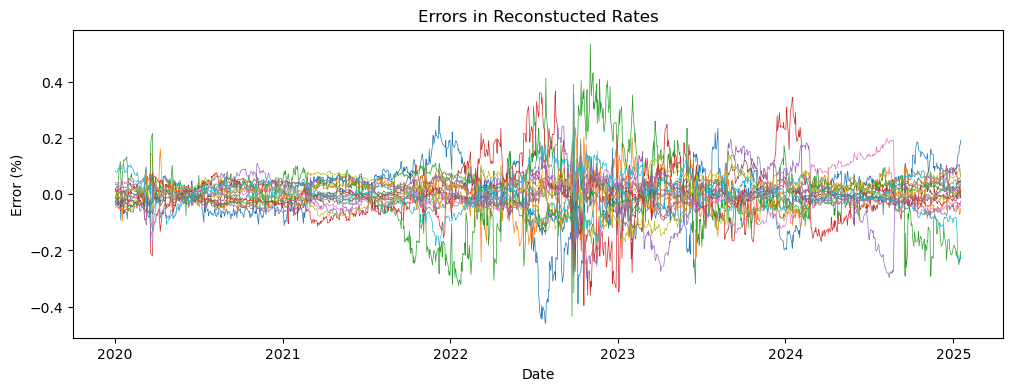

In [752]:
# Assessing accuracy of recompositio
fig, ax = plt.subplots(figsize=(12,4), ncols=1, nrows=1)
ax.plot(residuals.index, residuals, lw=0.5)
ax.set(title='Errors in Reconstucted Rates', xlabel='Date', ylabel='Error (%)')
plt.show()

C:\Users\ddoko\AppData\Local\Temp\ipykernel_25724\3502300998.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tenors, rotation = 50)


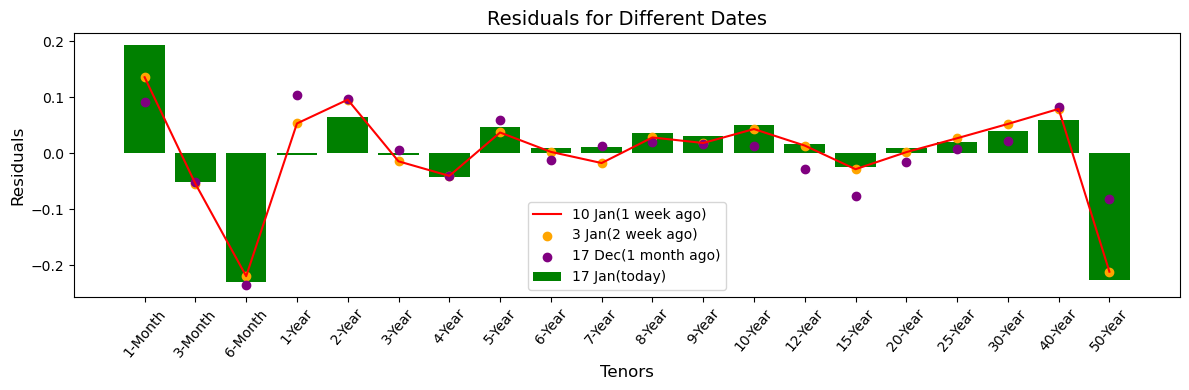

In [814]:
fig, ax = plt.subplots(figsize=(12,4))
ax.bar(residuals.loc['2025-01-17'].index, residuals.loc['2025-01-17'].values, label="17 Jan(today)", color= "green")
ax.plot(residuals.loc['2025-01-10'],label="10 Jan(1 week ago)", color="red")
ax.scatter(residuals.loc['2025-01-03'].index, residuals.loc['2025-01-10'].values, label="3 Jan(2 week ago)", color="orange")
ax.scatter(residuals.loc['2024-12-17'].index, residuals.loc['2024-12-17'].values, label="17 Dec(1 month ago)", color="purple")


# Add labels, title, and legend
ax.set_title('Residuals for Different Dates', fontsize=14)
ax.set_xlabel('Tenors', fontsize=12)
ax.set_ylabel('Residuals', fontsize=12)
ax.set_xticklabels(tenors, rotation = 50)

ax.legend(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

***


## Applications of PCA results

### Fixed-Income Trading Concepts

#### Steepeners and Flatteners
- **Steepeners**: A trade betting on an increase in the yield spread between short and long maturities.
- **Flatteners**: A trade betting on a decrease in the yield spread.

In this analysis, the 1m6m steepener trade idea emerged from the PCA residuals, suggesting that the front end of the curve is undervalued.

#### Butterflies (Flys)
- A butterfly trade captures relative value between the wings (short and long maturities) and the body (intermediate maturity).
- This can be implemented using a combination of futures or swaps to target specific parts of the curve.

#### Yield Curve Dynamics
- Yield curves reflect market expectations for interest rates, inflation, and growth.
- PCA helps dissect these dynamics into actionable insights, linking the residuals to market positioning and potential mispricings.


### Trade Idea: 1m6m Steepener

Based on PCA residuals, the 1m6m spread appears undervalued, suggesting an opportunity to profit from front-end steepening. This could be driven by:
- Expectations of higher short-term rates due to hawkish central bank policy.
- Market repricing of liquidity risks.

#### Trade Structure
- Long 6-month SONIA futures.
- Short 1-month SONIA futures.
- Monitor spread movements to manage risk.

### Trade Idea: Long 50-Year Yield
The 50-year yield shows signs of undervaluation in the residual analysis. A potential driver for rising long-end yields includes increased issuance of ultra-long gilts or a rise in the term premium.


***

## Conclusion

This analysis demonstrates how PCA can be used to identify relative value opportunities in the UK yield curve. By combining data analysis, statistical methods, and market knowledge, we identified two potential trades:
1. A 1m6m steepener to capture front-end steepening.
2. A long 50-year rate trade to position for a rise in ultra-long yields.

This project showcases a blend of technical skills, quantitative expertise, and a deep understanding of fixed-income markets, making it highly relevant for macro-focused trading roles.


# Try a

<Axes: xlabel='Date'>

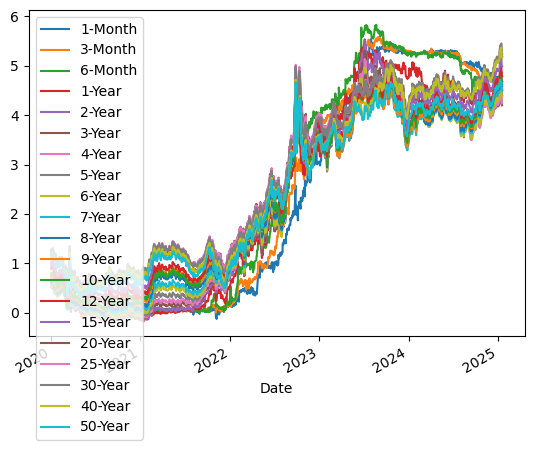

In [755]:
uk_yields.plot()

In [756]:
df = uk_yields.copy()

In [757]:
def plot_rates(df):
    plot_vars = df.columns
    
    fig, ax = plt.subplots(figsize=(8,4), ncols=1, nrows=1)
    for var in plot_vars:
        ax.plot(df.index, df[var], label=var, lw=0.5)
    ax.set(title='Daily Interest Rate', xlabel='Date', ylabel='Interest Rate (%)')
    fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))
    plt.show()

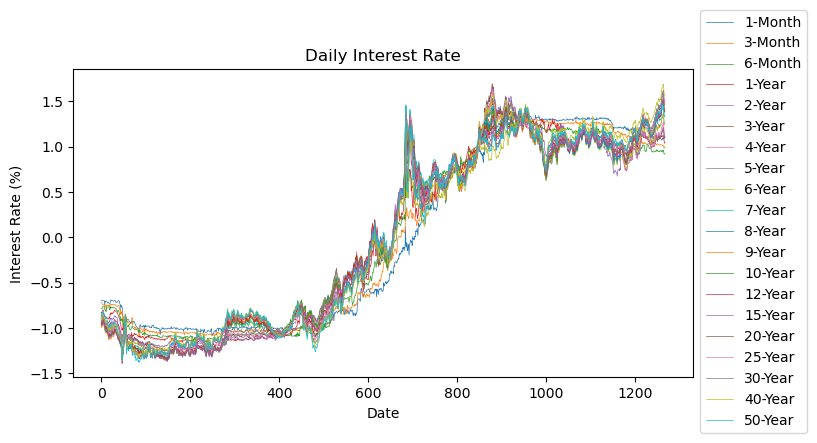

In [758]:
# Create instance of scalar
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(np.array(df)))
df_scaled.columns = df.columns

# Plot the scalared dataset
plot_rates(df_scaled)

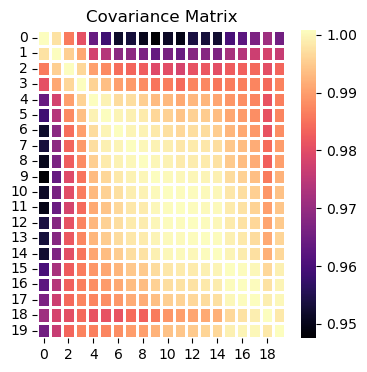

In [759]:
# Compute covariance matrix
X = np.array(df_scaled)
cov = (X.T @ X) / (X.shape[0] - 1)

# Display the covariance matix
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(cov, cmap='magma',linecolor='white',linewidths=1, ax=ax)
ax.set(title="Covariance Matrix")
plt.show()

In [760]:
# Eigenvalue and eigenvectors
eig_values, eig_vectors = np.linalg.eig(cov)

# View the eigenvalues and vectors
print("Eigenvalues:\t", eig_values[0])
print("Eigenvectors:\t", eig_vectors[0])

Eigenvalues:	 19.77783625144002
Eigenvectors:	 [ 0.2179084   0.61560922 -0.08735175 -0.3827995   0.39104864 -0.01623628
  0.01256097 -0.17860881  0.02154642 -0.41472732  0.05109897 -0.13806264
  0.18904092  0.03488281  0.01697975 -0.03530861  0.02658328 -0.02764817
 -0.00480197  0.00400737]


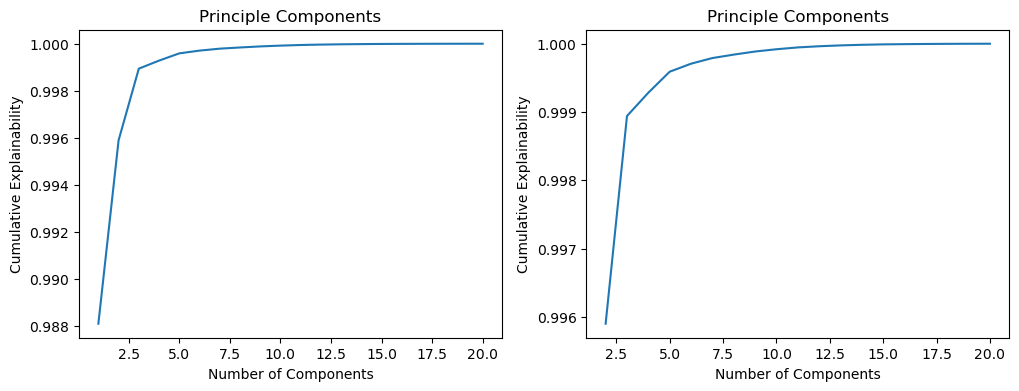

In [761]:
# Sort the eigenvectors
idx = np.argsort(eig_values, axis=0)[::-1]
sorted_eig_vectors = eig_vectors[:, idx]

# Cumulative sum of the eigenvalues
cumsum = np.cumsum(eig_values[idx]) / np.sum(eig_values[idx])
xint = range(1, len(cumsum) + 1)

# Plot the explainability by the number of components
fig, ax = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
ax[0].plot(xint, cumsum)
ax[0].set(title='Principle Components', xlabel='Number of Components', ylabel='Cumulative Explainability')

ax[1].plot(xint[1:], cumsum[1:])
ax[1].set(title='Principle Components', xlabel='Number of Components', ylabel='Cumulative Explainability')
plt.show()

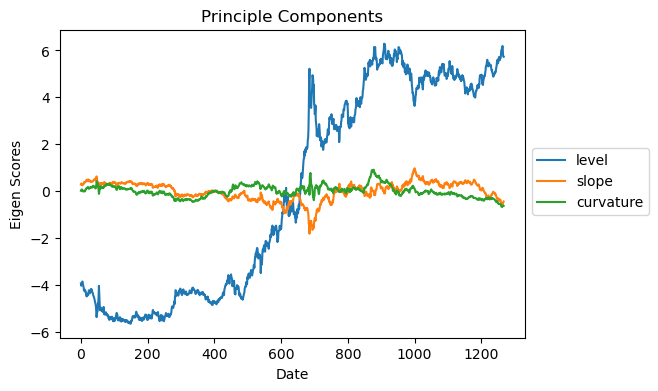

                 PC1       PC2       PC3
Date                                    
2025-01-06  5.683884 -0.383466 -0.553880
2025-01-07  5.814805 -0.450661 -0.588503
2025-01-08  6.011659 -0.539391 -0.645913
2025-01-09  6.023819 -0.560717 -0.668348
2025-01-10  6.080785 -0.566203 -0.660708
2025-01-13  6.170872 -0.613824 -0.640867
2025-01-14  6.186325 -0.616520 -0.651699
2025-01-15  5.844161 -0.505297 -0.616637
2025-01-16  5.734612 -0.468978 -0.617512
2025-01-17  5.728739 -0.439902 -0.623985


In [762]:
pc_scores = np.dot(X, sorted_eig_vectors[:, :3])

fig, ax = plt.subplots(figsize=(6,4), ncols=1, nrows=1)
for i, pca in enumerate(['level','slope','curvature']):
    ax.plot(pc_scores[:,i], label=pca)
ax.set(title='Principle Components', xlabel='Date', ylabel='Eigen Scores')
fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))
plt.show()

df_pca = pd.DataFrame(pc_scores, columns=['PC1','PC2','PC3'])
df_pca.index = df.index

print(df_pca.tail(10))

Principle Component Score Array Shape:	 (1268, 3)


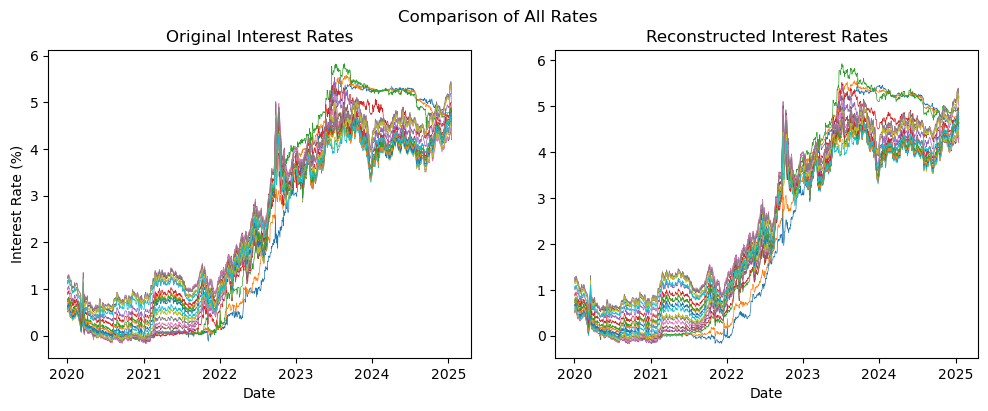

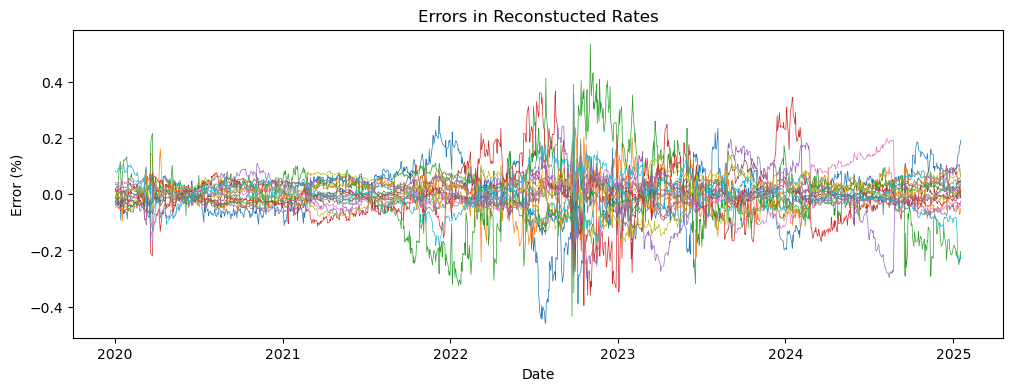

In [763]:
# Reconstruct the standardised interest rates
reconstructed_scaled_rates = np.dot(pc_scores, sorted_eig_vectors[:, :3].T)

# Remove standardisation
reconstructed_rates = scaler.inverse_transform(reconstructed_scaled_rates)

print("Principle Component Score Array Shape:\t", pc_scores.shape)

# Plotting before and after PCA
plot_vars = df.columns
fig, ax = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
plt.suptitle('Comparison of All Rates')
ax[0].plot(df.index, df[plot_vars], lw=0.5)
ax[0].set(title='Original Interest Rates', xlabel='Date', ylabel='Interest Rate (%)')

ax[1].plot(df.index, reconstructed_rates, lw=0.5)
ax[1].set(title='Reconstructed Interest Rates', xlabel='Date')
plt.show()

# Assessing accuracy of recomposition
errors = np.array(df[plot_vars]) - reconstructed_rates

fig, ax = plt.subplots(figsize=(12,4), ncols=1, nrows=1)
ax.plot(df.index, errors, lw=0.5)
ax.set(title='Errors in Reconstucted Rates', xlabel='Date', ylabel='Error (%)')
plt.show()

In [764]:
pd.DataFrame(sorted_eig_vectors[:, :3].T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.217908,0.220620,0.222734,0.223543,0.223898,0.224076,0.224041,0.224282,0.224179,0.224186,0.224376,0.224256,0.224473,0.224497,0.224371,0.224444,0.224386,0.224301,0.223357,0.224096
1,0.615609,0.490003,0.298966,0.203305,0.011889,-0.056480,-0.126520,-0.134670,-0.160458,-0.194865,-0.170566,-0.185949,-0.150695,-0.149982,-0.157328,-0.087099,-0.058810,-0.012906,0.064035,-0.008842
2,-0.087352,0.036015,0.200054,0.227345,0.338942,0.329709,0.272230,0.196880,0.186258,0.070136,0.001967,-0.053487,-0.023122,-0.044417,-0.104710,-0.224107,-0.262731,-0.299496,-0.447181,-0.313108


In [765]:
loadings[:3]

,1-Month,3-Month,6-Month,1-Year,2-Year,3-Year,4-Year,5-Year,6-Year,7-Year,8-Year,9-Year,10-Year,12-Year,15-Year,20-Year,25-Year,30-Year,40-Year,50-Year
0,0.217908,0.220620,0.222734,0.223543,0.223898,0.224076,0.224041,0.224282,0.224179,0.224186,0.224376,0.224256,0.224473,0.224497,0.224371,0.224444,0.224386,0.224301,0.223357,0.224096
1,-0.615609,-0.490003,-0.298966,-0.203305,-0.011889,0.056480,0.126520,0.134670,0.160458,0.194865,0.170566,0.185949,0.150695,0.149982,0.157328,0.087099,0.058810,0.012906,-0.064035,0.008842
2,-0.087352,0.036015,0.200054,0.227345,0.338942,0.329709,0.272230,0.196880,0.186258,0.070136,0.001967,-0.053487,-0.023122,-0.044417,-0.104710,-0.224107,-0.262731,-0.299496,-0.447181,-0.313108


In [766]:
loadings_keep.T

,1-Month,3-Month,6-Month,1-Year,2-Year,3-Year,4-Year,5-Year,6-Year,7-Year,8-Year,9-Year,10-Year,12-Year,15-Year,20-Year,25-Year,30-Year,40-Year,50-Year
PC1,0.217908,0.220620,0.222734,0.223543,0.223898,0.224076,0.224041,0.224282,0.224179,0.224186,0.224376,0.224256,0.224473,0.224497,0.224371,0.224444,0.224386,0.224301,0.223357,0.224096
PC2,-0.615609,-0.490003,-0.298966,-0.203305,-0.011889,0.056480,0.126520,0.134670,0.160458,0.194865,0.170566,0.185949,0.150695,0.149982,0.157328,0.087099,0.058810,0.012906,-0.064035,0.008842
PC3,-0.087352,0.036015,0.200054,0.227345,0.338942,0.329709,0.272230,0.196880,0.186258,0.070136,0.001967,-0.053487,-0.023122,-0.044417,-0.104710,-0.224107,-0.262731,-0.299496,-0.447181,-0.313108
